# COVID-19 Prediction Model for Maryland

## Part 3 - Feature Engineering and Hyperparameter Tuning

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from bokeh.models import NumeralTickFormatter, DatetimeTickFormatter, ColumnDataSource, HoverTool, CrosshairTool, SaveTool, PanTool, Range1d
from bokeh.plotting import figure, show, output_file
from bokeh.models import Line,TapTool
from bokeh.io import output_notebook, show
output_notebook()

import os

from multiprocessing import Pool

import farmhash

import xgboost as xgb
from xgboost import plot_importance


from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import r2_score

from sklearn.model_selection import TimeSeriesSplit
from skopt.space import Real,Categorical, Integer
from skopt import BayesSearchCV

Loading BokehJS ...

### Import Data

The below loads JHU's Covid-19 data using multiprocessing and corrects for inconsistent formatting across the CSV files.

In [2]:
# load data in parallel

def read_csv(file):
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    
    tmp = pd.read_csv(path + file)
    
    # the various try code blocks correct for inconsistencies between subsequent data files.
    try:
        tmp['Province_State']
    except KeyError:
        tmp = tmp.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region', 'Last Update': 'Last_Update'})
        tmp['Admin2'] = np.NaN
        tmp['FIPS'] = np.NaN
        tmp = tmp.astype({'Admin2': 'str', 'FIPS': 'float64'})
    
    try:
        tmp['Lat']
    except KeyError:
        tmp = tmp.rename(columns={'Latitude': 'Lat', 'Longitude': 'Long_'})
        
    try:
        tmp['Incidence_Rate']
    except KeyError:
        tmp = tmp.rename(columns={'Incident_Rate': 'Incidence_Rate'})
    
    try:
        tmp['Case-Fatality_Ratio']
    except KeyError:
        tmp = tmp.rename(columns={'Case_Fatality_Ratio': 'Case-Fatality_Ratio'})
    
    
    # Retain only those rows associated with the US
    tmp = tmp[tmp['Country_Region'] == 'US']
    
    # Extract the date from the filename
    file_date = file[-14:-4]
    
    # Date for EDA
    tmp['Data_Date'] = file_date
    tmp['Data_Date'] = pd.to_datetime(tmp['Data_Date'])
    
    # Date_Block field for easier sorting
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5])) # this adds the filename date as a new column
    
    return tmp


def parallel_load():

    granular_covid_data = pd.read_csv("COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/10-03-2020.csv")
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    files = os.listdir(path)
    file_list = [filename for filename in files if filename.split('.')[1]=='csv']

    with Pool(processes=4) as pool:

        df_list = pool.map(read_csv, file_list)

        granular_covid_data = pd.concat(df_list, ignore_index=True)
    
    return granular_covid_data

#### Load all data and apply fixes from Part 1 (EDA)

In [3]:
### case data ###
granular_covid_data = parallel_load()
granular_covid_data = granular_covid_data.sort_values(by = ['Province_State', 'FIPS', 'Date_Block'])
#################

### testing data ###
covid_data = pd.DataFrame()

path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports_us/*.csv"

for file in glob.glob(path):
    tmp = pd.read_csv(file)
    file_date = file[-14:-4] #this extracts the date from the filename
    
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5]))
    
    # handle different column names with the same testing data
    if 'People_Tested' in tmp.columns:
        tmp = tmp.rename(columns={"People_Tested": 'Total_Test_Results'})

    covid_data = pd.concat([covid_data,tmp])

covid_data = covid_data.sort_values(by = ['Province_State', 'Date_Block'])

covid_data = covid_data[['Province_State', 'Total_Test_Results', 'Date_Block']]

granular_covid_data = pd.merge(granular_covid_data, covid_data, on = ["Province_State", 'Date_Block'], how = 'left')

## fix for problem 1 
granular_covid_data['Total_Test_Results'] = granular_covid_data['Total_Test_Results'].shift(-1).fillna(0).clip(lower = 0)
####################



### vaccination data ###
vaxx_data = pd.read_csv("CDC/COVID-19_Vaccinations_in_the_United_States_County.csv")
vaxx_data = vaxx_data[['Date', 'FIPS', 'Series_Complete_Pop_Pct', 'Series_Complete_Yes', 'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct']]

vaxx_data['Date'] = pd.to_datetime(vaxx_data['Date'])
vaxx_data['Date_Block'] = vaxx_data['Date'].dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block
vaxx_data = vaxx_data[vaxx_data['FIPS'] != "UNK"] # drop rows where FIPS is unknown
vaxx_data['FIPS'] = vaxx_data['FIPS'].astype(int)
vaxx_data.drop(['Date'], axis = 1, inplace = True)

granular_covid_data = pd.merge(granular_covid_data, vaxx_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)
#######################


### land area ###
land_area = pd.read_excel("Census/LND01.xls")
land_area = land_area[['STCOU', 'LND110210D']]
land_area = land_area.rename(columns={"STCOU": 'FIPS', "LND110210D": 'Land_Area'})
granular_covid_data = pd.merge(granular_covid_data, land_area, on = ["FIPS"], how = 'left').fillna(0)
#################

### travel data ###
travel_data = pd.read_csv("DOT/Trips_by_Distance.csv")
travel_data['Date_Block'] = pd.to_datetime(travel_data['Date']).dt.strftime('%Y%m%d').astype(int) # convert dates to yyyymmdd format, like Date_Block

# keep only county-level data
travel_data = travel_data[travel_data['Level'] == 'County']
travel_data.drop(['Level', 'Date', 'State FIPS', 'State Postal Code', 'County Name', 'Row ID', 'Week', 'Month'], axis = 1, inplace = True)
travel_data = travel_data.rename(columns={'County FIPS': 'FIPS', 'Number of Trips <1': 'Number of Trips lt 1', 'Number of Trips >=500': 'Number of Trips gt 500'})

## fix for problem 3
# replace NaNs -- originally replaced with zeros -- with 5 day exponential moving average

travel_cols = ['Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'Number of Trips lt 1', 'Number of Trips 1-3',
       'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips gt 500']
for col in travel_cols:
    travel_data[col] = travel_data.groupby(['FIPS'])[col].fillna(travel_data[col].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean()))

granular_covid_data = pd.merge(granular_covid_data, travel_data, on = ["FIPS", 'Date_Block'], how = 'left').fillna(0)
########################


### weather data ###
weather_data = pd.read_csv("NOAA/Dulles_2020.csv")
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2021.csv")])
weather_data = pd.concat([weather_data, pd.read_csv("NOAA/Dulles_2022.csv")])[['DATE', 'SOURCE', 'TMP', 'DEW', 'SLP']]  #Date, measurement source id, temperature, dewpoint, pressure 

weather_data['Data_Date'] = pd.to_datetime(weather_data['DATE'])
weather_data['Date_Block'] = weather_data['Data_Date'].dt.strftime('%Y%m%d').astype(int)

# retain data from one weather station.
weather_data = weather_data[weather_data['SOURCE']==4]

# convert tmp, dew and slp from the encoded format to usable data
weather_data['Temperature'] = -9999
weather_data['Dew_Point'] = -9999
weather_data['Pressure'] = -9999

for i in range(len(weather_data)):
    weather_data.iloc[i,7] = int(weather_data.iloc[i,2][:-2])/10 #temperature
    weather_data.iloc[i,8] = int(weather_data.iloc[i,3][:-2])/10 #dew point
    weather_data.iloc[i,9] = int(weather_data.iloc[i,4][:-2])/10 #pressure

# Drop rows with suspect pressure numbers
weather_data = weather_data[weather_data['Pressure'] < 2000] 

weather_data = weather_data.drop(['DATE','SOURCE', 'TMP', 'DEW', 'SLP', 'Data_Date'], axis = 1)
weather_data = weather_data.groupby('Date_Block').mean()
weather_data = weather_data.reset_index()

# merge weather data
granular_covid_data = pd.merge(granular_covid_data, weather_data, on = ['Date_Block'], how = 'left')

# fix nans in weather data
granular_covid_data['Temperature'] = granular_covid_data['Temperature'].fillna(granular_covid_data['Temperature'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)
granular_covid_data['Dew_Point'] = granular_covid_data['Dew_Point'].fillna(granular_covid_data['Dew_Point'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)
granular_covid_data['Pressure'] = granular_covid_data['Pressure'].fillna(granular_covid_data['Pressure'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)

###################


### basic features ###
# calculate new cases
granular_covid_data['New_Cases'] = granular_covid_data['Confirmed'].diff(periods = 1).fillna(0).clip(lower = 0)

# calculate new tests
### fix for problem 4
# if change in total tests exceeds a threshold amount, replace with NaN, then replace new tests with moving average
granular_covid_data.loc[(granular_covid_data['Total_Test_Results'].diff(periods = 1) / granular_covid_data['Total_Test_Results'] >= .1), 'Total_Test_Results'] = np.nan

granular_covid_data['New_Tests'] = granular_covid_data['Total_Test_Results'].diff(periods = 1)
granular_covid_data['New_Tests'] = granular_covid_data['New_Tests'].fillna(granular_covid_data['New_Tests'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean())).clip(lower = 0)

## fix for problem 2, identifying days where data is not reported and identifying days where the data is aggregated to include weekends.
granular_covid_data['Is_Data_Reported'] = 1
granular_covid_data['Is_Data_Reported'] = np.where(
    ((granular_covid_data['New_Cases'] == 0.0) & (granular_covid_data['New_Tests'] == 0.0)), 0, 1)
granular_covid_data['Data_Lumped'] = granular_covid_data['Is_Data_Reported'].diff(periods = 1).fillna(0).clip(lower = 0)


## fix for problem 7
# The total number of tests performed between 12-05 and 12-26 is 798752
# Assume that an equal number of tests are performed each day. 
# not perfect but better than assume no tests occured. Zero tests or a large number of tests would impact Test_Positivity.

for dateblock in range(20211205,20211227):
    granular_covid_data.loc[(granular_covid_data['Province_State'] == 'Maryland') & (granular_covid_data['Date_Block']==dateblock), 'New_Tests'] = 798752//21



### Add population.
imputed_population = granular_covid_data[granular_covid_data['Date_Block'] == 20200529]
imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)

cols = ['Admin2', 'Province_State', 'Population']
tmp = imputed_population[cols]
granular_covid_data = pd.merge(granular_covid_data, tmp, on = ['Admin2', 'Province_State'], how = 'left')

granular_covid_data = granular_covid_data.dropna(subset=['Date_Block','FIPS', 'Population']).reset_index().drop(['index'], axis=1) #this is to drop the unclassified FIPS
granular_covid_data = granular_covid_data[granular_covid_data['Admin2'] != "Unassigned"] # drops unassigned counties (Delaware related)

# Add test positivity rate. Not perfect as this calculates county-level new cases divided by state-wide new tests. 
# So this is like a contribution to the state's positivity rate.
granular_covid_data['Test_Positivity'] = (granular_covid_data['New_Cases'] / granular_covid_data['New_Tests'])

#some dates have no new tests but positive new cases. this will cause inf
granular_covid_data.replace([np.inf], np.nan, inplace = True)

##### fix for problem 5
# for those days where test positivity exceeds 1, replace with NaN, then the below will replace NaNs with moving averages.
granular_covid_data.loc[(granular_covid_data['Test_Positivity'] >= 1), 'Test_Positivity'] = np.nan

# replace NaNs with 5 day exponential moving average
granular_covid_data['Test_Positivity'] = granular_covid_data.groupby(['FIPS'])['Test_Positivity'].fillna(granular_covid_data['Test_Positivity'].transform(lambda x: x.ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean()))

granular_covid_data['Infection_Rate_Per_Square_Mile'] = (granular_covid_data['New_Cases']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['One_Dose_Rate_Per_Square_Mile'] = (granular_covid_data['Administered_Dose1_Recip']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Full_Vaxx_Rate_Per_Square_Mile'] = (granular_covid_data['Series_Complete_Yes']/granular_covid_data['Population'])/granular_covid_data['Land_Area']
granular_covid_data['Test_Pos_Rate_Per_Square_Mile'] = (granular_covid_data['Test_Positivity']/granular_covid_data['Population'])/granular_covid_data['Land_Area']

#granular_covid_data['Percent_People_Staying_Home'] = granular_covid_data['Population Staying at Home'] / (granular_covid_data['Population Staying at Home'] + granular_covid_data['Population Not Staying at Home'])

/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (36,45,57,62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/roman/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (42,43,44,54,59,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-3-1ebd6147b9bd>:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_population['Population'] = imputed_population['Confirmed']//(imputed_population['Incidence_Rate']/100000)


### Feature Engineering

#### Include neighboring State data

In [4]:
md_granular = granular_covid_data[(granular_covid_data['Province_State'] == 'Maryland') | (granular_covid_data['Province_State'] == 'Virginia') | (granular_covid_data['Province_State'] == 'District of Columbia')]
md_granular = md_granular.dropna(subset=['Date_Block','FIPS']).reset_index().drop(['index'], axis=1)

# generate our target variable
md_granular['Cases_14_Days_Forward'] = md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])['New_Cases'].shift(-14).fillna(0)

#### Add lagged features

In [5]:
periods = [3,7,14,21]

for t in periods:
    col_name = 'Infection_Rate_Per_Square_Mile_Lag_' + str(t)
    md_granular[col_name] = md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])['Infection_Rate_Per_Square_Mile'].shift(t).fillna(0.0)
    
    col_name = 'Test_Pos_Rate_Per_Square_Mile_Lag_' + str(t)
    md_granular[col_name] = md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])['Test_Pos_Rate_Per_Square_Mile'].shift(t).fillna(0.0)

#### Add de-trending features

In [6]:
md_granular['Day_of_Week'] = md_granular['Date_Block']%7 + 1
md_granular['Month'] = md_granular['Date_Block'].astype(str).apply(lambda x: x[4:6]).astype(int)

for i in periods:
    md_granular['New_Cases_Diff_' + str(i)] = md_granular['New_Cases'].diff(periods = i).fillna(0)

#### Add exponential moving averages

In [7]:
for ew_period in periods:
    md_granular[str(ew_period) + '_Day_Rolling_EW_Infection_Rate_Per_Square_Mile']=md_granular.sort_values(['FIPS','Date_Block']).groupby('FIPS')['Infection_Rate_Per_Square_Mile'].transform(lambda x: x.ewm(span=ew_period,min_periods=0,adjust=False,ignore_na=False).mean())
    md_granular[str(ew_period) + '_Day_Rolling_EW_New_Cases']=md_granular.sort_values(['FIPS','Date_Block']).groupby('FIPS')['New_Cases'].transform(lambda x: x.ewm(span=ew_period,min_periods=0,adjust=False,ignore_na=False).mean())
    md_granular[str(ew_period) + '_Day_Rolling_EW_Test_Pos_Rate_Per_Square_Mile']=md_granular.sort_values(['FIPS','Date_Block']).groupby('FIPS')['Test_Pos_Rate_Per_Square_Mile'].transform(lambda x: x.ewm(span=ew_period,min_periods=0,adjust=False,ignore_na=False).mean())

#### Group travel features and express them as a percent of the population

In [8]:
md_granular['Percent_Staying_Home'] = md_granular['Population Staying at Home']/(md_granular['Population Staying at Home']+md_granular['Population Not Staying at Home'])
md_granular['Short_Trips'] = (md_granular['Number of Trips lt 1'] + md_granular['Number of Trips 1-3'] + md_granular['Number of Trips 3-5'] + md_granular['Number of Trips 5-10'])/(md_granular['Population Staying at Home']+md_granular['Population Not Staying at Home'])
md_granular['Medium_Trips'] = (md_granular['Number of Trips 10-25'] + md_granular['Number of Trips 25-50'] + md_granular['Number of Trips 50-100'])/(md_granular['Population Staying at Home']+md_granular['Population Not Staying at Home'])
md_granular['Long_Trips'] = (md_granular['Number of Trips 100-250'] + md_granular['Number of Trips 250-500'] + md_granular['Number of Trips gt 500'])/(md_granular['Population Staying at Home']+md_granular['Population Not Staying at Home'])

md_granular = md_granular.drop(['Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'Number of Trips lt 1', 'Number of Trips 1-3',
       'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips gt 500'], axis = 1)

#### Add hashed features

In [9]:
md_granular['Hashed_FIPS'] = md_granular['FIPS']
md_granular['Hashed_Date_Block'] = md_granular['Date_Block']

for i in range(len(md_granular)):
    md_granular.iloc[i, md_granular.columns.get_loc('Hashed_FIPS')] = int(farmhash.hash64(str(md_granular.iloc[i, md_granular.columns.get_loc('Hashed_FIPS')]))) % 7
    md_granular.iloc[i, md_granular.columns.get_loc('Hashed_Date_Block')] = int(farmhash.hash64(str(md_granular.iloc[i, md_granular.columns.get_loc('Hashed_Date_Block')]))) % 15    

#### Add Potential Future Cases Based on R0

In [10]:
# Estimated R0 multiplied by an EWMA and shifted, like a lagged feature.
# R0 source: https://www.sciencedirect.com/science/article/pii/S0022519321000436

r0 = 5.8

for i in periods:
    md_granular['R0_' + str(i) + '_Day_Rolling_EW_Potential_New_Cases'] = r0 * md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])[str(i) + '_Day_Rolling_EW_New_Cases'].shift(i).fillna(0.0)

### Train updated model

In [11]:
engineered_data = md_granular.drop(['Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Data_Date', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio','Total_Test_Results', 'Confirmed', 'New_Tests', 'Deaths', 'Test_Positivity'], axis = 1)
engineered_data = engineered_data.sort_values(by = ['FIPS', 'Date_Block'])

In [12]:
X_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220126)]
y_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220126)]['Cases_14_Days_Forward']

X_validation = engineered_data[(engineered_data['Date_Block'] > 20220126) & (engineered_data['Date_Block'] <= 20220127)]
y_validation = engineered_data[(engineered_data['Date_Block'] > 20220126) & (engineered_data['Date_Block'] <= 20220127)]['Cases_14_Days_Forward']

X_train = X_train.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)
X_validation = X_validation.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

In [13]:
# a dateblock of Jan 28 here means we are making a prediction for February 11, which is 14 days forward.
X_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]
y_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]['Cases_14_Days_Forward']

X_test = X_test.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

In [14]:
params = {
        'learning_rate': .1,
        'max_depth': 9,
        'subsample': .5,
        'colsample_bytree': .5, 
        'eval_metric': 'poisson-nloglik',
        'objective': 'count:poisson',
        'seed': 42,
        'tree_method': 'gpu_hist',
        'sampling_method': 'gradient_based',
        'alpha': 1,
        'lambda': 1,
        'gamma': 1
    }

watchlist = [
    (xgb.DMatrix(X_train, y_train), 'train'),
    (xgb.DMatrix(X_validation, y_validation), 'validation')
]

progress = dict()

improved_model = xgb.train(params, xgb.DMatrix(X_train, y_train), 50000,  watchlist, maximize=False, verbose_eval=100, early_stopping_rounds=500, evals_result = progress)

[0]	train-poisson-nloglik:124.34096	validation-poisson-nloglik:145.96916
[100]	train-poisson-nloglik:6.94319	validation-poisson-nloglik:9.93598
[200]	train-poisson-nloglik:3.36308	validation-poisson-nloglik:9.10698
[300]	train-poisson-nloglik:3.15129	validation-poisson-nloglik:9.09227
[400]	train-poisson-nloglik:3.02242	validation-poisson-nloglik:9.02151
[500]	train-poisson-nloglik:2.94177	validation-poisson-nloglik:8.89663
[600]	train-poisson-nloglik:2.86362	validation-poisson-nloglik:8.98436
[700]	train-poisson-nloglik:2.81510	validation-poisson-nloglik:8.98583
[800]	train-poisson-nloglik:2.76913	validation-poisson-nloglik:8.98001
[900]	train-poisson-nloglik:2.73078	validation-poisson-nloglik:8.92705
[991]	train-poisson-nloglik:2.69614	validation-poisson-nloglik:8.92534


In [15]:
prediction = improved_model.predict(xgb.DMatrix(X_test), ntree_limit=improved_model.best_ntree_limit).round(0)

# Date here is Feb 11 because we want Feb 11 actual numbers to compare to predicted Feb 11 cases generated using January 28 data.
md_test = md_granular[(md_granular['Date_Block'] == 20220211)][['FIPS', 'Admin2', 'New_Cases', 'Population']].sort_values(by = ['FIPS']) 
cols = ['Admin2', 'FIPS', 'Population', 'New_Cases']
results = md_test[cols]
results['Predicted'] = prediction

md_counties = md_granular[(md_granular['Province_State'] == 'Maryland')]['Population'].unique()
results = results[results['Population'].isin(md_counties)]
results

/home/roman/anaconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
<ipython-input-15-e26b7f953c62>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Predicted'] = prediction


,Admin2,FIPS,Population,New_Cases,Predicted
1392,Allegany,24001.0,70415.0,22.0,35.0
2094,Anne Arundel,24003.0,579234.0,91.0,123.0
2796,Baltimore,24005.0,827369.0,86.0,139.0
3498,Calvert,24009.0,92524.0,18.0,29.0
4200,Caroline,24011.0,33405.0,4.0,12.0
4902,Carroll,24013.0,168447.0,41.0,49.0
5604,Cecil,24015.0,102855.0,36.0,32.0
6306,Charles,24017.0,163256.0,31.0,40.0
7007,Dorchester,24019.0,31929.0,14.0,19.0
7709,Frederick,24021.0,259547.0,60.0,66.0


In [16]:
mean_poisson_deviance(results['New_Cases'], results['Predicted'])

7.042676585694753

In [17]:
r2_score(results['New_Cases'], results['Predicted'])

0.7438202943134836

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

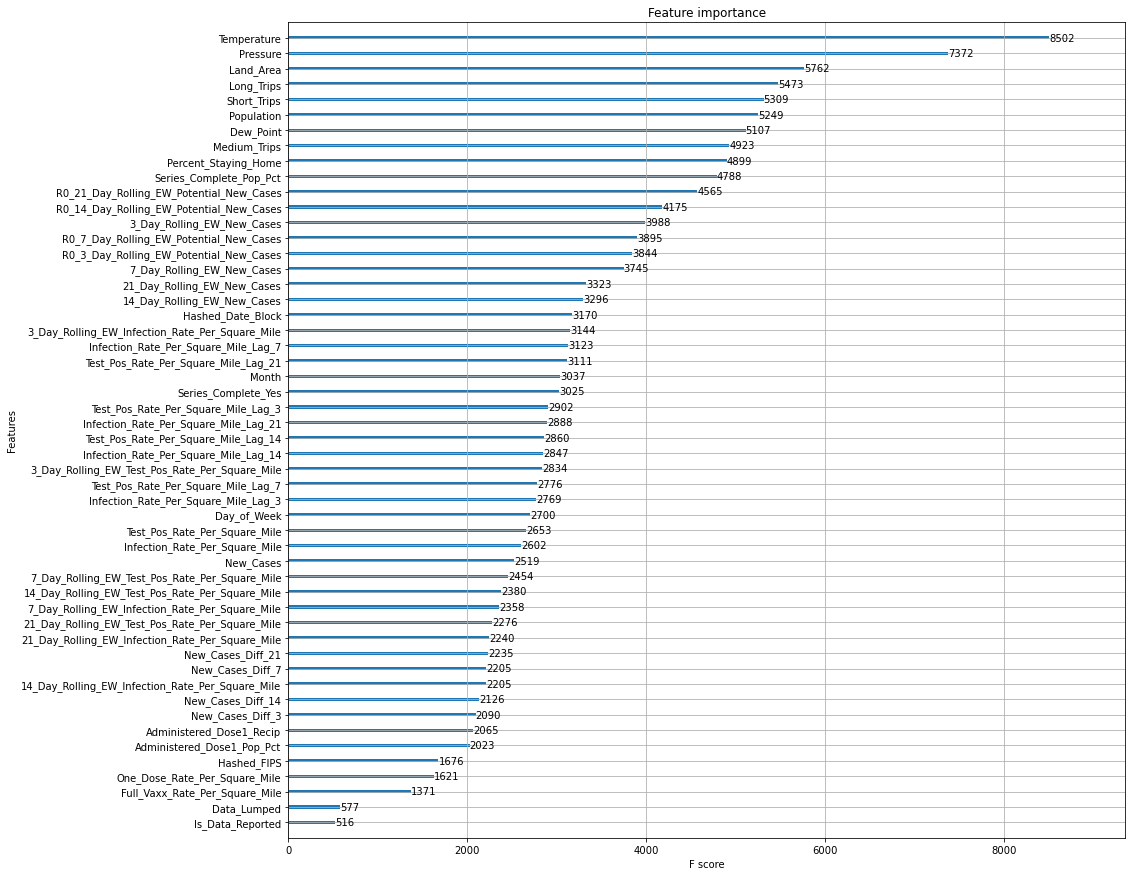

In [18]:
# Plot feature importance
plt.rcParams["figure.figsize"] = (15, 15)
plot_importance(improved_model)

### Hyperparameter tuning

In [ ]:
X_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220127)]
y_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220127)]['Cases_14_Days_Forward']

X_train = X_train.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

X_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]
y_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]['Cases_14_Days_Forward']

X_test = X_test.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

In [ ]:
xg_reg = xgb.XGBRegressor()
ts_split = TimeSeriesSplit(n_splits=15, test_size = 1)

search_params = {
    'eval_metric': Categorical(['poisson-nloglik']),
    'objective': Categorical(['count:poisson']),
    'learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'seed': Categorical([42]),
    'tree_method': Categorical(['gpu_hist']),
    'sampling_method': Categorical(['gradient_based']),
    
    'max_depth': Integer(1, 16),
    'subsample': Real(0.5, 1.0, prior="log-uniform"),
    'colsample_bytree': Real(0.5, 1.0, prior="log-uniform"),
    'colsample_bylevel': Real(0.5, 1.0, prior="log-uniform"),
    'colsample_bynode': Real(0.5, 1.0, prior="log-uniform"),
    'alpha': Integer(0, 10),
    'lambda': Integer(0, 10),
    'gamma': Integer(0, 10)
}

bayesian_search = BayesSearchCV(xg_reg,search_params, scoring = 'neg_mean_poisson_deviance', cv=ts_split, verbose=1,n_jobs=4, n_iter=100)
bayesian_search.fit(X_train, y_train)

In [ ]:
print(f"validation score: {bayesian_search.best_score_}")
print(f"test score: {bayesian_search.score(X_test, y_test)}")
print(f"best parameters: {str(bayesian_search.best_params_)}")

### Re-run with optimized hyperparameters

In [19]:
engineered_data = md_granular.drop(['Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Data_Date', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio','Total_Test_Results', 'Confirmed', 'New_Tests', 'Deaths', 'Test_Positivity'], axis = 1)
engineered_data = engineered_data.sort_values(by = ['FIPS', 'Date_Block'])

In [20]:
X_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220126)]
y_train = engineered_data[(engineered_data['Date_Block'] > 20200415) & (engineered_data['Date_Block'] <= 20220126)]['Cases_14_Days_Forward']

X_validation = engineered_data[(engineered_data['Date_Block'] > 20220126) & (engineered_data['Date_Block'] <= 20220127)]
y_validation = engineered_data[(engineered_data['Date_Block'] > 20220126) & (engineered_data['Date_Block'] <= 20220127)]['Cases_14_Days_Forward']

X_train = X_train.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)
X_validation = X_validation.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

In [21]:
# a dateblock of Jan 28 here means we are making a prediction for February 11, which is 14 days forward.
X_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]
y_test = engineered_data[(engineered_data['Date_Block'] == 20220128)]['Cases_14_Days_Forward']

X_test = X_test.drop(['FIPS', 'Date_Block', 'Cases_14_Days_Forward'], axis = 1)

In [22]:
params = {
        'learning_rate': 0.19103471981170686,
        'max_depth': 12,
        'subsample': 1.0,
        'colsample_bytree': 0.5,
        'colsample_bylevel': 0.5,
        'colsample_bynode': 0.5,
        'eval_metric': 'poisson-nloglik',
        'objective': 'count:poisson',
        'seed': 42,
        'tree_method': 'gpu_hist',
        'sampling_method': 'gradient_based',
        'alpha': 8,
        'lambda': 10,
        'gamma': 0
    }

watchlist = [
    (xgb.DMatrix(X_train, y_train), 'train'),
    (xgb.DMatrix(X_validation, y_validation), 'validation')
]

progress = dict()

improved_model = xgb.train(params, xgb.DMatrix(X_train, y_train), 50000,  watchlist, maximize=False, verbose_eval=100, early_stopping_rounds=500, evals_result = progress)

[0]	train-poisson-nloglik:122.68314	validation-poisson-nloglik:143.59485
[100]	train-poisson-nloglik:2.67236	validation-poisson-nloglik:9.88369
[200]	train-poisson-nloglik:2.18477	validation-poisson-nloglik:9.49921
[300]	train-poisson-nloglik:1.99652	validation-poisson-nloglik:9.42998
[400]	train-poisson-nloglik:1.89914	validation-poisson-nloglik:9.32401
[500]	train-poisson-nloglik:1.83339	validation-poisson-nloglik:9.26723
[600]	train-poisson-nloglik:1.78855	validation-poisson-nloglik:9.19601
[700]	train-poisson-nloglik:1.75798	validation-poisson-nloglik:9.22263
[800]	train-poisson-nloglik:1.73583	validation-poisson-nloglik:9.20904
[900]	train-poisson-nloglik:1.71713	validation-poisson-nloglik:9.18929
[1000]	train-poisson-nloglik:1.70485	validation-poisson-nloglik:9.17585
[1100]	train-poisson-nloglik:1.69292	validation-poisson-nloglik:9.16351
[1200]	train-poisson-nloglik:1.68339	validation-poisson-nloglik:9.15986
[1300]	train-poisson-nloglik:1.67604	validation-poisson-nloglik:9.16236


In [23]:
prediction = improved_model.predict(xgb.DMatrix(X_test), ntree_limit=improved_model.best_ntree_limit).round(0)

md_test = md_granular[(md_granular['Date_Block'] == 20220211)][['FIPS', 'Admin2', 'New_Cases', 'Population']].sort_values(by = ['FIPS']) 
cols = ['Admin2', 'FIPS', 'Population', 'New_Cases']
results = md_test[cols]
results['Predicted'] = prediction

md_counties = md_granular[(md_granular['Province_State'] == 'Maryland')]['Population'].unique()
results = results[results['Population'].isin(md_counties)]
results

/home/roman/anaconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
<ipython-input-23-5548bfd6d52d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Predicted'] = prediction


,Admin2,FIPS,Population,New_Cases,Predicted
1392,Allegany,24001.0,70415.0,22.0,40.0
2094,Anne Arundel,24003.0,579234.0,91.0,109.0
2796,Baltimore,24005.0,827369.0,86.0,114.0
3498,Calvert,24009.0,92524.0,18.0,18.0
4200,Caroline,24011.0,33405.0,4.0,8.0
4902,Carroll,24013.0,168447.0,41.0,30.0
5604,Cecil,24015.0,102855.0,36.0,38.0
6306,Charles,24017.0,163256.0,31.0,34.0
7007,Dorchester,24019.0,31929.0,14.0,23.0
7709,Frederick,24021.0,259547.0,60.0,54.0


In [24]:
mean_poisson_deviance(results['New_Cases'], results['Predicted'])

5.200849657472858

In [25]:
r2_score(results['New_Cases'], results['Predicted'])

0.8596771945762082

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

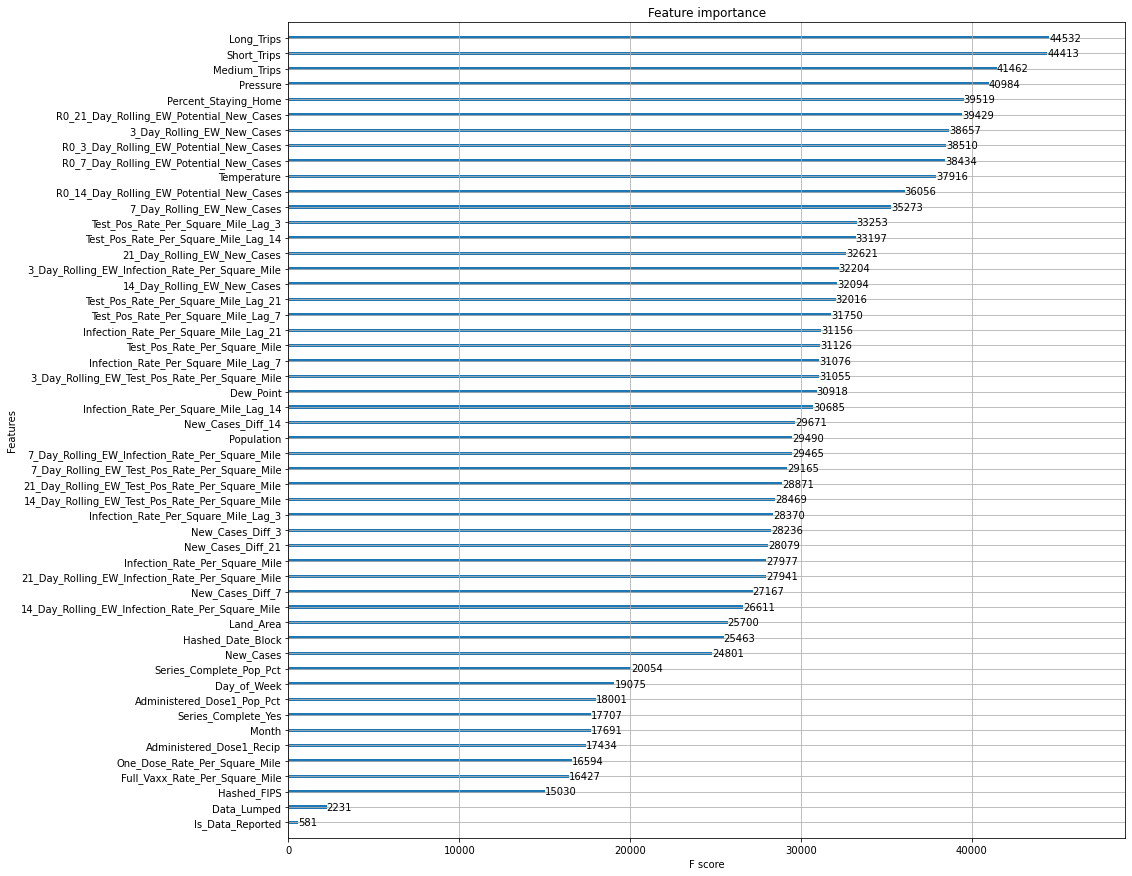

In [26]:
# Plot feature importance
plt.rcParams["figure.figsize"] = (15, 15)
plot_importance(improved_model)